In [18]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [19]:
# 1. Definición de parámetros y constantes
ALL_MONEDAS_RADIOS_MM = {
    '2 EURO': 12.875, '50 CENT': 12.125, '1 EURO': 11.625, 
    '20 CENT': 11.125, '5 CENT': 10.625, '10 CENT': 9.875, 
    '2 CENT': 9.375, '1 CENT': 8.125,
}
VALORES = {
    '2 EURO': 2.00, '1 EURO': 1.00, '50 CENT': 0.50, '20 CENT': 0.20,
    '10 CENT': 0.10, '5 CENT': 0.05, '2 CENT': 0.02, '1 CENT': 0.01
}
TOLERANCIA_MAXIMA_MM = 0.40  # tolerancia para considerar si una moneda coincide

HOUGH_PARAMS = {
    'minDist': 120, 'param1': 180, 'param2': 40, 'minRadius': 50, 'maxRadius': 160
}

# calculamos el punto medio entre 50 cent y 1 euro para corrección
R_50C = ALL_MONEDAS_RADIOS_MM['50 CENT']
R_1E = ALL_MONEDAS_RADIOS_MM['1 EURO']
SOGLIA_50C_1E = (R_50C + R_1E) / 2

In [34]:
# 2. Carga y preprocesamiento de la imagen, con imagen ideal
#img = cv2.imread('rsc/TAREA1/Monedas.jpg')
# 2. Carga y preprocesamiento de la imagen, con imagen no a escala
#img = cv2.imread('rsc/TAREA1/monete.jpg')
# 2. Carga y preprocesamiento de la imagen, con foto tomada
img = cv2.imread('rsc/TAREA1/foto.jpeg')

if img is None: 
    print("ERROR: No se pudo cargar la imagen 'monete.jpg'.")
    exit()
    
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # imagen original en RGB
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # convertimos a gris
pimg = cv2.GaussianBlur(gris, (13, 13), 0)    # suavizamos con blur

# detectar círculos con Hough
circ = cv2.HoughCircles(
    pimg, cv2.HOUGH_GRADIENT, 1, HOUGH_PARAMS['minDist'], 
    param1=HOUGH_PARAMS['param1'], param2=HOUGH_PARAMS['param2'], 
    minRadius=HOUGH_PARAMS['minRadius'], maxRadius=HOUGH_PARAMS['maxRadius'],
)

# si no hay círculos, inicializamos vacío
if circ is None: 
    monedas_detectadas = np.array([])
else: 
    monedas_detectadas = np.uint16(np.around(circ))[0]

In [35]:
# 3. Calibración global del tamaño
somma_rapporti_pixel_mm = 0
contatore_riferimenti = 0
riferimenti_ideali = list(ALL_MONEDAS_RADIOS_MM.values())

if monedas_detectadas.size > 0:
    max_r_pixel = np.max(monedas_detectadas[:, 2])  # radio más grande en pixeles
    for x, y, r_pixel in monedas_detectadas:
        r_stimato_mm_grezzo = r_pixel * (12.875 / max_r_pixel)  # estimación mm
        r_ideale = min(riferimenti_ideali, key=lambda r: abs(r - r_stimato_mm_grezzo))  # moneda más cercana
        rapporto_mm_pixel = r_ideale / r_pixel
        somma_rapporti_pixel_mm += rapporto_mm_pixel
        contatore_riferimenti += 1

# factor de conversión mm/pixel
if contatore_riferimenti == 0:
    FACTOR_CONVERSION = 1 
else:
    FACTOR_CONVERSION = somma_rapporti_pixel_mm / contatore_riferimenti

print(f"Riferimenti usati per media: {contatore_riferimenti}")
print(f"Factor de Conversión (mm/pixel): {FACTOR_CONVERSION:.4f}")

Riferimenti usati per media: 0
Factor de Conversión (mm/pixel): 1.0000


In [36]:
# 4. Clasificación de monedas
datos_clasificacion_monedas = [] 
if monedas_detectadas.size > 0: 
    for x, y, r_pixel in monedas_detectadas:
        r_estimato_mm = r_pixel * FACTOR_CONVERSION  # radio estimado en mm
        min_error = float('inf')
        clase_trovada = 'NO CLASIFICADA' 
        valor_euro = 0.0
        best_match = None
        
        # buscamos la moneda más cercana por tamaño
        for nombre_moneda, r_mm_ideale in ALL_MONEDAS_RADIOS_MM.items():
            error = abs(r_estimato_mm - r_mm_ideale)
            if error < min_error:
                min_error = error
                best_match = (nombre_moneda, VALORES[nombre_moneda])
            
        # corrección especial para 50c / 1€
        error_50c = abs(r_estimato_mm - R_50C)
        error_1e = abs(r_estimato_mm - R_1E)
        if error_50c <= TOLERANCIA_MAXIMA_MM or error_1e <= TOLERANCIA_MAXIMA_MM:
            if r_estimato_mm >= SOGLIA_50C_1E:
                best_match = ('50 CENT', VALORES['50 CENT'])
                min_error = error_50c
            if best_match[0] == '50 CENT':
                min_error = error_50c
            elif best_match[0] == '1 EURO':
                min_error = error_1e
        
        # asignamos clase final si error dentro de tolerancia
        if best_match is not None and min_error <= TOLERANCIA_MAXIMA_MM:
            clase_trovada, valor_euro = best_match
            
        # guardamos datos de la moneda
        datos_clasificacion_monedas.append({
            'centro': (x, y),
            'radio_pixel': r_pixel,
            'nombre': clase_trovada,
            'valor': valor_euro,
            'radio_mm': r_estimato_mm,
            'cliccata': False
        })


In [37]:
# 5. Variables globales para interacción
img_base_limpia = img_rgb.copy() 
monedas_glob = datos_clasificacion_monedas
total_denaro_interactivo = 0.0

In [38]:

# 6. Función para click en la moneda
def mostra_dettagli_moneta(event, x, y, flags, param):
    global total_denaro_interactivo
    global monedas_glob 

    if event == cv2.EVENT_LBUTTONDOWN:
        for i, moneta in enumerate(monedas_glob):
            cx, cy = moneta['centro']
            r = moneta['radio_pixel']
            dist_quadrata = (x - cx)*2 + (y - cy)*2
            if dist_quadrata <= r**2:
                if not moneta['cliccata']:
                    total_denaro_interactivo += moneta['valor']
                    monedas_glob[i]['cliccata'] = True 
                break 

        img_temp = img_base_limpia.copy()
        color_texto = (255, 255, 255) 
        for moneta in monedas_glob:
            if moneta['cliccata']:
                cx, cy = moneta['centro']
                r_pixel = moneta['radio_pixel']
                nombre = moneta['nombre']
                r_mm = moneta['radio_mm']
                valor = moneta['valor']
                colore_disegno = (0, 255, 0) if valor > 0 else (255, 0, 0)
                cv2.circle(img_temp, (cx, cy), r_pixel, colore_disegno, 3) 
                cv2.putText(img_temp, f"{nombre} ({r_mm:.2f}mm)", (cx - 40, cy + 5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_texto, 2)
        
        resumen_texto_acumulado = f"TOTAL ACUMULADO: {total_denaro_interactivo:.2f} EURO"
        cv2.putText(img_temp, resumen_texto_acumulado, (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
        cv2.imshow("Resultado Clasificacion Interactivo", img_temp)


In [ ]:
# 7. Visualización interactiva
cv2.namedWindow("Resultado Clasificacion Interactivo")
cv2.setMouseCallback("Resultado Clasificacion Interactivo", mostra_dettagli_moneta)
cv2.imshow("Resultado Clasificacion Interactivo", img_base_limpia)

while True:
    k = cv2.waitKey(20) & 0xFF
    if k == 27:  # salir con ESC
        break

cv2.destroyAllWindows()


In [26]:
# 8. Resumen final en consola
print("\n--- RESUMEN FINAL INTERACTIVO ---")
print(f"VALOR TOTAL CONTADO (por click): {total_denaro_interactivo:.2f} €")


--- RESUMEN FINAL INTERACTIVO ---
VALOR TOTAL CONTADO (por click): 2.52 €


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo SMACC: A System for Microplastics Automatic Counting and Classification, las características geométricas utilizadas fueron:

Área en píxeles
Perímetro en píxeles
Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
Relación del área de la partícula con la del contenedor
Relación del ancho y el alto del contenedor
Relación entre los ejes de la elipse ajustada
Definido el centroide, relación entre las distancias menor y mayor al contorno
Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [12]:
#1. PREPARACIÓN DE LOS DATOS DE ENTRENAMIENTO

# Defino dónde están las imágenes con las rutas correctas
image_paths = {
    "FRA": ["rsc/TAREA2/FRA.png"],
    "PEL": ["rsc/TAREA2/PEL.png"],
    "TAR": ["rsc/TAREA2/TAR.png"]
}

# También actualizo las rutas de los archivos de prueba
test_image_path = "rsc/TAREA2/MPs_test.jpg"
test_csv_path = "rsc/TAREA2/MPs_test_bbs.csv"

# Defino una carpeta donde voy a guardar las imágenes aumentadas
output_dir = Path("rsc/Augmented_Student/")  # Crea la carpeta en el mismo lugar que el script
output_dir.mkdir(parents=True, exist_ok=True)

print("Estoy creando más imágenes para el entrenamiento (volteadas)...")
for label, paths in image_paths.items():
    for i, path in enumerate(paths):
        image = cv2.imread(path)
        if image is None:
            print(f"ATENCIÓN: Imagen no encontrada en {path}. Se salta este archivo.")
            continue
        
        # Guardo la imagen original y su versión volteada (espejo)
        cv2.imwrite(str(output_dir / f"{label}_{i}_orig.png"), image)
        flipped_image = cv2.flip(image, 1)  # 1 = volteo horizontal
        cv2.imwrite(str(output_dir / f"{label}_{i}_flip.png"), flipped_image)

print("Imágenes de entrenamiento listas.\n")


Estoy creando más imágenes para el entrenamiento (volteadas)...
Imágenes de entrenamiento listas.



libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [13]:
def extract_geometric_features(image):
    # Si la imagen está vacía o no existe, salimos
    if image is None or image.size == 0: 
        return None
    
    # Convertimos la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicamos un umbral automático (binario invertido + Otsu)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Buscamos los contornos externos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: 
        return None
    
    # Tomamos el contorno más grande (la partícula principal)
    main_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(main_contour)
    if area < 50: 
        return None
    
    # --- Características de forma ---
    perimeter = cv2.arcLength(main_contour, True)
    compactness = (perimeter ** 2) / area if area > 0 else 0
    
    # Rectángulo que contiene la partícula
    x, y, w, h = cv2.boundingRect(main_contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Convex hull (envolvente convexa)
    hull = cv2.convexHull(main_contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / float(hull_area) if hull_area > 0 else 0
    
    # Calculamos el brillo medio solo dentro de la partícula (usando la máscara 'thresh')
    mean_gray_value = cv2.mean(gray, mask=thresh)[0]
    
    # Devolvemos todas las características calculadas
    return {
        'area': area,
        'perimeter': perimeter,
        'compactness': compactness,
        'aspect_ratio': aspect_ratio,
        'solidity': solidity,
        'mean_gray_value': mean_gray_value  # Nueva característica añadida
    }


In [14]:
#3. ENTRENAMIENTO DEL MODELO
print("Extrayendo las características (features) de las imágenes de entrenamiento...")
X_train = []
y_train = []

for img_path in sorted(output_dir.glob("*.png")):
    label = img_path.name.split('_')[0]  # El nombre antes del guion bajo es la etiqueta
    image = cv2.imread(str(img_path))
    features = extract_geometric_features(image)
    if features:
        X_train.append(list(features.values()))
        y_train.append(label)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajustamos el escalador y transformamos los datos

# Creamos y entrenamos el modelo CON LOS DATOS ESCALADOS
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, y_train)  # Usamos X_train_scaled
print("Modelo KNN entrenado!\n")


Extrayendo las características (features) de las imágenes de entrenamiento...
Modelo KNN entrenado!



In [15]:
#4. TEST Y EVALUACIÓN
print("Comenzando la prueba con la imagen MPs_test.jpg...")
test_img = cv2.imread(test_image_path)
df_test = pd.read_csv(test_csv_path)
y_true = []
y_pred = []

for index, row in df_test.iterrows():
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    true_label = row['label'].strip().upper()
    roi = test_img[y1:y2, x1:x2]  # Recortamos la zona de interés (ROI)
    features = extract_geometric_features(roi)
    
    if features:
        features_for_prediction = [list(features.values())]
        
        features_scaled = scaler.transform(features_for_prediction)
        
        # Hacemos la predicción CON LOS DATOS ESCALADOS
        prediction = model.predict(features_scaled)[0]
        
        y_true.append(true_label)
        y_pred.append(prediction)
    else:
        y_true.append(true_label)
        y_pred.append("ERROR") 

# Calculamos la precisión (accuracy) del modelo
accuracy = accuracy_score(y_true, y_pred)
labels = ["FRA", "PEL", "TAR"]
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

print(f"RESULTADO: Precisión del modelo = {accuracy*100:.2f}%\n")


Comenzando la prueba con la imagen MPs_test.jpg...
RESULTADO: Precisión del modelo = 49.48%



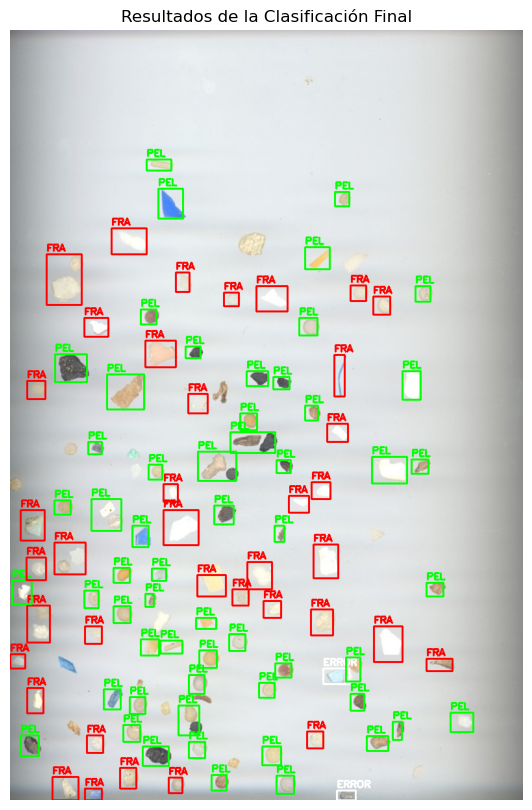

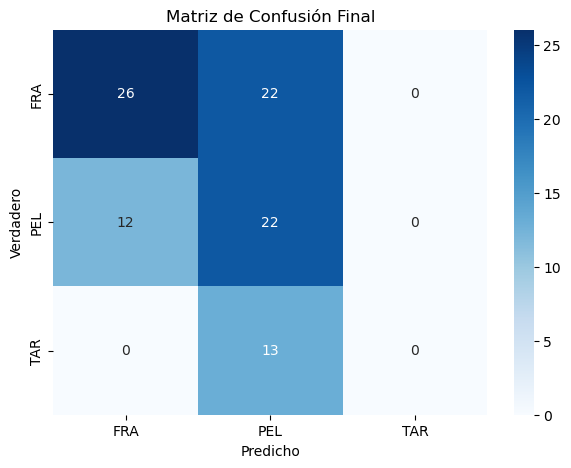

In [17]:
#5. VISUALIZACIÓN DE LOS RESULTADOS
vis_img = test_img.copy()

# Colores para cada clase
color_map = {
    "FRA": (0, 0, 255),     # Rojo
    "PEL": (0, 255, 0),     # Verde
    "TAR": (255, 0, 0),     # Azul
    "ERROR": (255, 255, 255) # Blanco
}

# Dibujamos rectángulos y etiquetas sobre la imagen
for i, row in df_test.iterrows():
    if i >= len(y_pred): 
        break
    x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    pred_label = y_pred[i]
    color = color_map.get(pred_label)
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(vis_img, pred_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Mostramos la imagen con las predicciones
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title("Resultados de la Clasificación Final")
plt.axis("off")
plt.show()

# Mostramos la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión Final")
plt.show()
